In [ ]:
import boto3, re
import sagemaker
from sagemaker import get_execution_role
import os
import numpy as np
import tensorflow as tf
import utils
import pandas as pd
import zipfile
import tfrecord_conversion
from sagemaker.predictor import csv_serializer, json_deserializer

sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket='tensorflow-rul'
prefix='RUL'

In [ ]:
# source_data_location = 's3://sagemaker-solutions-us-west-2/Predictive-maintenance-using-machine-learning/data'

# #local data folder
# data_folder = 'data'

# !aws s3 cp --recursive $source_data_location $data_folder


# with zipfile.ZipFile(os.path.join(data_folder, 'CMAPSSData.zip'), "r") as zip_ref:
#     zip_ref.extractall(data_folder)

In [ ]:
# train_df, test_df, columns = utils.preprocess_data(data_folder)
# test_set = pd.DataFrame()
# for i in train_df:
#     train_set=pd.DataFrame(i)

# for i in test_df:
#     test_set=pd.DataFrame(i)
# test_set.to_csv('test_set.csv')
# print(test_set.shape[1])


train_set = pd.read_csv('newtrain.csv', index_col = 0)
test_set = pd.read_csv('newtest.csv', index_col = 0)

dataset = tfrecord_conversion.data_preprocess(train_set, test_set)

In [ ]:
!mkdir 'tfrecord_data'
tfrecord_conversion.convert_to(dataset["train_dict"], 'train', 'tfrecord_data')
tfrecord_conversion.convert_to(dataset["test_dict"], 'test', 'tfrecord_data')

mkdir: cannot create directory ‘tfrecord_data’: File exists
Writing tfrecord_data/train.tfrecords

Writing tfrecord_data/test.tfrecords


In [ ]:
inputs = sagemaker_session.upload_data(path='tfrecord_data',bucket=bucket, key_prefix='data/RUL_Tfrecord')

In [ ]:
!cat dnn_regressor.py

import os
import numpy as np
import tensorflow as tf
from tensorflow.python.estimator.model_fn import ModeKeys as Modes

INPUT_TENSOR_NAME = 'inputs'
SIGNATURE_NAME = 'predictions'
LEARNING_RATE = 0.001

from tensorflow.python.estimator.model_fn import ModeKeys as Modes

def model_fn(features, labels, mode, params):
    # Input Layer

    input_layer = tf.reshape(features[INPUT_TENSOR_NAME], [-1,26])




    # Dense Layer

    dense1 = tf.layers.dense(inputs=input_layer, units=256, activation=tf.nn.relu)
    drop1 = tf.layers.dropout(dense1, rate=0.5)
    dense2 = tf.layers.dense(inputs=dense1, units=128, activation=tf.nn.relu)
    drop2 = tf.layers.dropout(dense2, rate=0.5)
    dense3 = tf.layers.dense(inputs=dense2, units=64, activation=tf.nn.relu)
    drop3 = tf.layers.dropout(dense3, rate=0.5)
    logits = tf.layers.dense(inputs=drop3, units=1, activation=None)
    
    

    # Define operations
    predictions = tf.squeeze(logits,1) #tf.nn.softmax(logits, name='softmax_tensor')
  

In [ ]:
from sagemaker.tensorflow import TensorFlow
output_path = "s3://tensorflow-rul/RUL"

RUL_estimator = TensorFlow(entry_point='dnn_regressor.py',
                             role=role,
                             framework_version='1.11.0',
                             output_path = output_path,
                             training_steps=1000, 
                             evaluation_steps=100,
                             #early_stopping="true",
                             #patience="5",
                             train_instance_count=1,
                             train_instance_type='ml.c4.xlarge')

RUL_estimator.fit(inputs)

2.1.0 is the latest version of tensorflow that supports Python 2. Newer versions of tensorflow will only be available for Python 3.Please set the argument "py_version='py3'" to use the Python 3 tensorflow image.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-12 11:23:49 Starting - Starting the training job...
2020-10-12 11:23:51 Starting - Launching requested ML instances......
2020-10-12 11:24:54 Starting - Preparing the instances for training...
2020-10-12 11:25:40 Downloading - Downloading input data...
2020-10-12 11:26:15 Training - Training image download completed. Training in progress..2020-10-12 11:26:16,054 INFO - root - running container entrypoint
2020-10-12 11:26:16,054 INFO - root - starting train task
2020-10-12 11:26:16,068 INFO - container_support.training - Training starting
2020-10-12 11:26:19,850 INFO - tf_container - ----------------------TF_CONFIG--------------------------
2020-10-12 11:26:19,850 INFO - tf_container - {"environment": "cloud", "cluster": {"master": ["algo-1:2222"]}, "task": {"index": 0, "type": "master"}}
2020-10-12 11:26:19,850 INFO - tf_container - ---------------------------------------------------------
2020-10-12 11:26:19,851 INFO - tf_container - creating RunConfig:
2020-10-12 11:26:19,851

2020-10-12 11:26:27,443 INFO - tensorflow - Saving 'checkpoint_path' summary for global step 1000: s3://tensorflow-rul/RUL/sagemaker-tensorflow-2020-10-12-11-23-48-754/checkpoints/model.ckpt-1000
2020-10-12 11:26:27.581497: E tensorflow/core/platform/s3/aws_logging.cc:60] No response body. Response code: 404
2020-10-12 11:26:27.581553: W tensorflow/core/platform/s3/aws_logging.cc:57] If the signature check failed. This could be because of a time skew. Attempting to adjust the signer.
2020-10-12 11:26:27.601569: E tensorflow/core/platform/s3/aws_logging.cc:60] No response body. Response code: 404
2020-10-12 11:26:27.601607: W tensorflow/core/platform/s3/aws_logging.cc:57] If the signature check failed. This could be because of a time skew. Attempting to adjust the signer.
2020-10-12 11:26:27.618686: E tensorflow/core/platform/s3/aws_logging.cc:60] No response body. Response code: 404
2020-10-12 11:26:27.618727: W tensorflow/core/platform/s3/aws_logging.cc:57] If the signature check fail

In [ ]:
# output_path = '/'.join(RUL_estimator.output_path.split('/')[:-1])

# print(output_path)


# optimized_estimator = RUL_estimator.compile_model(target_instance_family='rasp3b',
#                               output_path=output_path,
#                               input_shape= {'data':[1,24]},  # Batch size 1, 3 channels, 224x224 Images.
#                               framework='tensorflow', framework_version='1.11.0')


In [ ]:
RUL_predictor = RUL_estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
2.1.0 is the latest version of tensorflow that supports Python 2. Newer versions of tensorflow will only be available for Python 3.Please set the argument "py_version='py3'" to use the Python 3 tensorflow image.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------!

In [ ]:
RUL_predictor.content_type = 'text/csv'
RUL_predictor.serializer = csv_serializer
RUL_predictor.deserializer = json_deserializer

In [ ]:
# test = test_set.drop(columns='id')
# test = test.drop(columns='cycle')
test=test_set
test = test.drop(columns='RUL')
test.to_csv('trial.csv')

In [ ]:
print(test.shape)

(13096, 26)


In [ ]:
test_dataset = pd.read_csv("trial.csv", index_col= 0)
test_feature_dataset = test_dataset[['id', 'cycle','setting1', 'setting2', 'setting3', 's1', 's2', 's3','s4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14','s15', 's16', 's17', 's18', 's19', 's20', 's21'
]]
#print(test_feature_dataset)
test_features = np.array(test_feature_dataset.values).astype('float32')

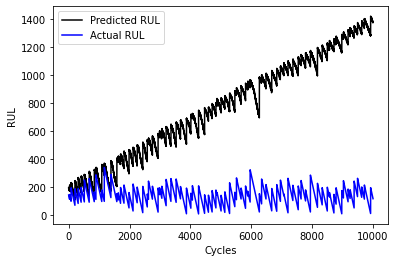

In [ ]:
x = []
y1 = []
y2 = [] 
    
for tf in range(10000):
    #print(test_features[tf])
    prediction = RUL_predictor.predict(test_features[tf])
    x.append(tf)
    y1.append(prediction['outputs']['Pred_RUL']['floatVal'][0])
    y2.append(test_set['RUL'].loc[tf])

    
#print(y1)    
import matplotlib.pyplot as plt 
#plt.scatter(x,y,label='Data')
plt.plot(x, y1, color='k', label='Predicted RUL')
plt.plot(x, y2, color='b', label='Actual RUL')

plt.xlabel('Cycles')
plt.ylabel('RUL')
plt.legend()
plt.savefig('testplot.png')